In [ ]:
# Lapaki Recommendation System ..... Art By JK Puku, A

## Task 2 : Machine Learning with Matrix Data for Recommender Systems

##### Probabilistic Matrix Factorization (PMF)

In [83]:
import os
from surprise import Dataset, Reader, SVD, KNNBasic
from surprise.model_selection import cross_validate

fpath = os.path.expanduser('/Users/rohitbathi/Desktop/Masters/sem2/DM/assignments/HW3/RecSys/ratings_small.csv')
reader = Reader(line_format="user item rating timestamp", sep=',')

data = Dataset.load_from_file(fpath, reader=reader)

pmf = SVD(biased=False)

cross_validate(pmf, data, measures=['rmse', 'mae'], cv=5, verbose=True)


Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0050  1.0064  1.0129  1.0094  1.0051  1.0077  0.0030  
MAE (testset)     0.7755  0.7762  0.7840  0.7807  0.7744  0.7782  0.0036  
Fit time          0.42    0.42    0.40    0.37    0.37    0.40    0.02    
Test time         0.04    0.27    0.04    0.03    0.19    0.11    0.10    


{'test_rmse': array([1.0050055 , 1.00640071, 1.01286604, 1.00938175, 1.00505349]),
 'test_mae': array([0.77554873, 0.77620991, 0.78401545, 0.7807146 , 0.77444474]),
 'fit_time': (0.42270374298095703,
  0.4163968563079834,
  0.398043155670166,
  0.36771082878112793,
  0.37178802490234375),
 'test_time': (0.039617061614990234,
  0.2717878818511963,
  0.035492658615112305,
  0.03187203407287598,
  0.1905968189239502)}

##### User based Collaborative Filtering

In [84]:
u_cf = KNNBasic(
    sim_options={
        'user_based':True
    }
)

cross_validate(u_cf, data, measures=['rmse', 'mae'], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9631  0.9738  0.9687  0.9698  0.9636  0.9678  0.0040  
MAE (testset)     0.7399  0.7479  0.7461  0.7461  0.7408  0.7441  0.0032  
Fit time          0.03    0.03    0.03    0.03    0.03    0.03    0.00    
Test time         0.37    0.37    0.36    0.48    0.36    0.39    0.05    


{'test_rmse': array([0.96310764, 0.97378192, 0.96870196, 0.96977478, 0.96356056]),
 'test_mae': array([0.7398907 , 0.74788512, 0.74605754, 0.7460504 , 0.74081927]),
 'fit_time': (0.03249621391296387,
  0.03367805480957031,
  0.033483028411865234,
  0.03333234786987305,
  0.034189701080322266),
 'test_time': (0.36573123931884766,
  0.3743429183959961,
  0.35719895362854004,
  0.48033595085144043,
  0.35570621490478516)}

##### Item based Collaborative Filtering

In [85]:
i_cf = KNNBasic(
    sim_options={
        'user_based':False
    }
)
cross_validate(pmf, data, measures=['rmse', 'mae'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0126  1.0125  1.0006  1.0065  1.0111  1.0087  0.0046  
MAE (testset)     0.7811  0.7825  0.7737  0.7763  0.7808  0.7789  0.0033  
Fit time          0.35    0.35    0.35    0.35    0.35    0.35    0.00    
Test time         0.03    0.15    0.03    0.03    0.03    0.06    0.05    


{'test_rmse': array([1.01261994, 1.01246943, 1.00060253, 1.00650096, 1.01114145]),
 'test_mae': array([0.78108209, 0.78247665, 0.77367067, 0.77629578, 0.78075901]),
 'fit_time': (0.34803295135498047,
  0.3462541103363037,
  0.34589219093322754,
  0.34612512588500977,
  0.35398292541503906),
 'test_time': (0.03165912628173828,
  0.15382814407348633,
  0.03284001350402832,
  0.03056192398071289,
  0.03123307228088379)}

##### Cosine similarity used in PMF, UCF, ICF

In [86]:
import os
from surprise import Dataset, Reader, KNNBasic
from surprise.model_selection import cross_validate

fpath = os.path.expanduser('/Users/rohitbathi/Desktop/Masters/sem2/DM/assignments/HW3/RecSys/ratings_small.csv')
reader = Reader(line_format="user item rating timestamp", sep=',')

data = Dataset.load_from_file(fpath, reader=reader)

cosine_ucf = KNNBasic(
    sim_options={
        'name': 'cosine',
        'user_based': True
    }
)
cosine_icf = KNNBasic(
    sim_options={
        'name': 'cosine',
        'user_based': False
    }
)

ucf_res = cross_validate(cosine_ucf, data, measures=['rmse','mae'], cv=5, verbose=False)
icf_res = cross_validate(cosine_icf, data, measures=['rmse','mae'], cv=5, verbose=False)

rmse_ucf_res = [np.mean(ucf_res['test_rmse'])]
mae_ucf_res = [np.mean(icf_res['test_mae'])]
rmse_icf_res = [np.mean(icf_res['test_rmse'])]
mae_icf_res = [np.mean(icf_res['test_mae'])]

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


##### Pearson similarity used in PMF, UCF, ICF

In [87]:
pearson_ucf = KNNBasic(
    sim_options={
        'name': 'pearson',
        'user_based': True
    }
)
pearson_icf = KNNBasic(
    sim_options={
        'name': 'pearson',
        'user_based': False
    }
)

ucf_res = cross_validate(pearson_ucf, data, measures=['rmse','mae'], cv=5, verbose=False)
icf_res = cross_validate(pearson_icf, data, measures=['rmse','mae'], cv=5, verbose=False)

rmse_ucf_res.append(np.mean(ucf_res['test_rmse']))
mae_ucf_res.append(np.mean(icf_res['test_mae']))
rmse_icf_res.append(np.mean(icf_res['test_rmse']))
mae_icf_res.append(np.mean(icf_res['test_mae']))

print(rmse_ucf_res)

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
[0.9920908899091614, 0.9989618171888198]


##### MSD similarity used in PMF, UCF, ICF

In [88]:
msd_ucf = KNNBasic(
    sim_options={
        'name': 'msd',
        'user_based': True
    }
)
msd_icf = KNNBasic(
    sim_options={
        'name': 'msd',
        'user_based': False
    }
)

ucf_res = cross_validate(msd_ucf, data, measures=['rmse','mae'], cv=5, verbose=False)
icf_res = cross_validate(msd_icf, data, measures=['rmse','mae'], cv=5, verbose=False)

rmse_ucf_res.append(np.mean(ucf_res['test_rmse']))
mae_ucf_res.append(np.mean(icf_res['test_mae']))
rmse_icf_res.append(np.mean(icf_res['test_rmse']))
mae_icf_res.append(np.mean(icf_res['test_mae']))


Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


##### Plotting error rates of different similarities in UCF and ICF

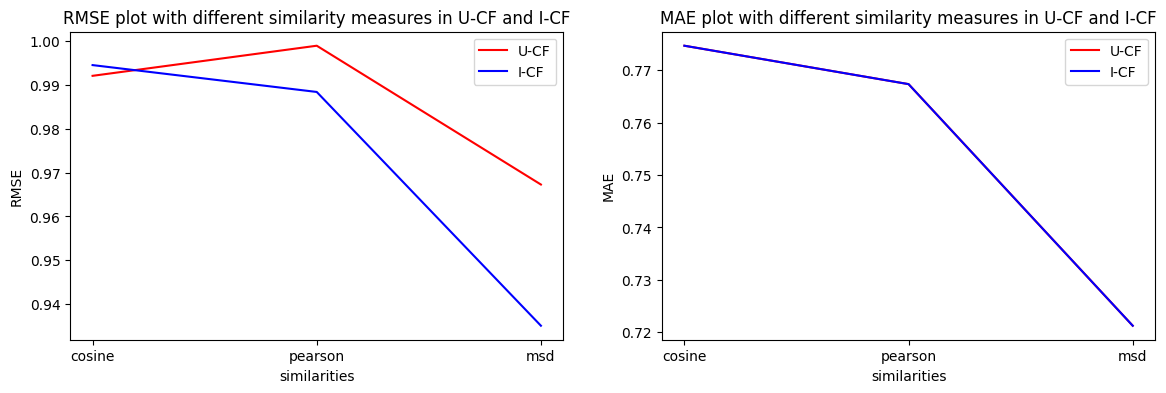

In [90]:
import matplotlib.pyplot as plt

names = ['cosine', 'pearson', 'msd']

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(14,4))

ax1.set_title('RMSE plot with different similarity measures in U-CF and I-CF')
ax1.plot(names, rmse_ucf_res, '-r', label='U-CF')
ax1.plot(names, rmse_icf_res, '-b', label='I-CF')
ax1.legend(loc='upper right')
ax1.set(xlabel='similarities', ylabel='RMSE')

ax2.set_title('MAE plot with different similarity measures in U-CF and I-CF')
ax2.plot(names, mae_ucf_res, 'r', label='U-CF')
ax2.plot(names, mae_icf_res, 'b', label='I-CF')
ax2.legend(loc='upper right')
ax2.set(xlabel='similarities', ylabel='MAE')

plt.show()

##### Plotting k-neightbour effect on U-CF and I-CF

In [104]:
ucf = None
icf=  None
rmse_ucf =  []
rmse_icf =  []
mae_ucf =  []
mae_icf =  []
for i in range(1,201, 10):
    ucf = KNNBasic(
        k = i,
        sim_options={
            'user_based': True
        }
    )
    icf = KNNBasic(
        k = i,
        sim_options={
            'user_based': False
        }
    )
    ucf_res = cross_validate(msd_ucf, data, measures=['rmse','mae'], cv=5, verbose=False)
    icf_res = cross_validate(msd_icf, data, measures=['rmse','mae'], cv=5, verbose=False)

    rmse_ucf.append(np.mean(ucf_res['test_rmse']))
    mae_ucf.append(np.mean(icf_res['test_mae']))
    rmse_icf.append(np.mean(icf_res['test_rmse']))
    mae_icf.append(np.mean(icf_res['test_mae']))

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

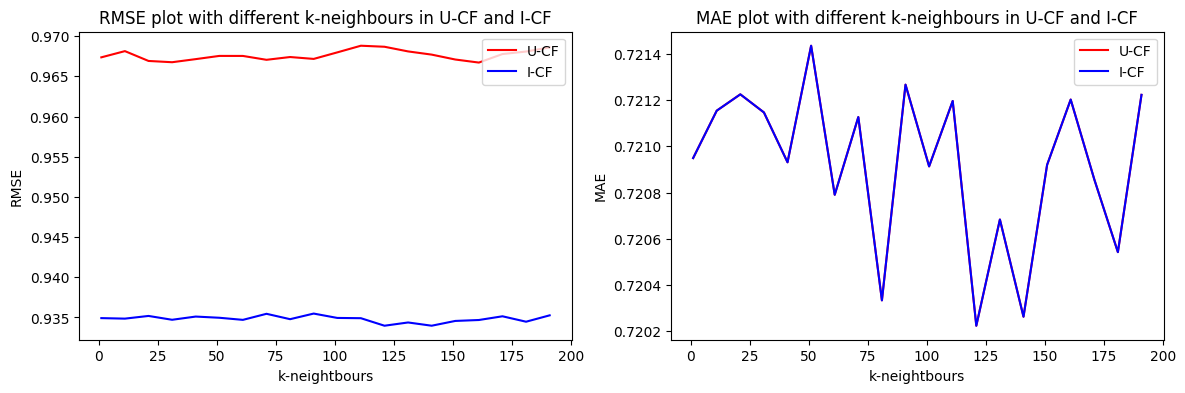

In [105]:
import matplotlib.pyplot as plt

xlabs = [i for i in range(1,201, 10)]

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(14,4))

ax1.set_title('RMSE plot with different k-neighbours in U-CF and I-CF')
ax1.plot(xlabs, rmse_ucf, '-r', label='U-CF')
ax1.plot(xlabs, rmse_icf, '-b', label='I-CF')
ax1.legend(loc='upper right')
ax1.set(xlabel='k-neightbours', ylabel='RMSE')

ax2.set_title('MAE plot with different k-neighbours in U-CF and I-CF')
ax2.plot(xlabs, mae_ucf, 'r', label='U-CF')
ax2.plot(xlabs, mae_icf, 'b', label='I-CF')
ax2.legend(loc='upper right')
ax2.set(xlabel='k-neightbours', ylabel='MAE')

plt.show()